In [1]:
from ROOT import TH1D, TCanvas, TF1, std
from pyLCIO import EVENT, UTIL, IOIMPL, IMPL
#from UTIL import CellIDDecoder
import matplotlib.pyplot as plt
import numpy as np

Welcome to JupyROOT 6.22/00
Loading LCIO ROOT dictionaries ...


In [2]:
import math
import sys
import string


class CellIDDecoder:

    """ decoder for LCIO cellIDs """

    def __init__(self,encStr):
        self.encStr=encStr
        self.funs = {} 

        tokens = encStr.split(',')
        
        offset = 0
        
        for t in tokens:
        
         # print "token: " , t
        
          st = t.split(':')
        
          if len(st)==2:
            name = st[0]
            start = offset 
            width = int(st[1])
            offset += abs( width )
        
          elif len(st)==3:
            name = st[0]
            start = int(st[1]) 
            width = int(st[2])
            offset = start + abs( width )
        
        
          else:
            print ("unknown token:" , t)
        
          mask = int(0x0)
          for i in range(0,abs(width)):
            mask = mask | ( 0x1 << ( i + start) )
        
          setattr( CellIDDecoder , name , self.makefun( mask, start , width) )


    def makefun(self, mask,start,width):
      if( width > 0 ):
        return ( lambda ignore, cellID : (( mask & cellID) >> start )  )
      else:
        return ( lambda ignore, cellID : (~(( mask & cellID) >> start )  ^ 0xffffffff) )

In [95]:
## returns fractional energy: first 20 layers and last 10 layers
def fracEsum(fName, maxEvt, collection):
    reader = IOIMPL.LCFactory.getInstance().createLCReader()
    reader.open( fName )
    
    esum20l = []
    esum10l = []

    
    nEvt = 0

    for evt in reader:
        nEvt += 1
        if nEvt > maxEvt:
                break
        ecalBarrel = evt.getCollection(collection)
        cellIDString = ecalBarrel.getParameters().getStringVal("CellIDEncoding")
        decoder = CellIDDecoder( cellIDString ) 
        esum20 = 0.0
        esum10 = 0.0 
        for hit in ecalBarrel:
            l = decoder.layer( hit.getCellID0() ) 
            e = hit.getEnergy() 
            #print ("Energy:", hit.getEnergy(), " Cell ID0:", hit.getCellID0(), " layer: ", decoder.layer( hit.getCellID0() )) 
            if l < 20:
                esum20 += e 
            elif l >= 20:
                esum10 = esum10 + e*2
        
        esum20l.append(esum20)
        esum10l.append(esum10)
        
    esum20np = np.asarray(esum20l)
    esum10np = np.asarray(esum10l)
    
    return esum20np, esum10np
    

In [4]:
def Esumhit(fName, maxEvt, collection):
    reader = IOIMPL.LCFactory.getInstance().createLCReader()
    reader.open( fName )
    
    esuml = []

    nEvt = 0

    for evt in reader:
        nEvt += 1
        if nEvt > maxEvt:
                break
        ecalBarrel = evt.getCollection(collection)
    
        cellIDString = ecalBarrel.getParameters().getStringVal("CellIDEncoding")
        decoder = CellIDDecoder( cellIDString ) 
        esum = 0.0
        for hit in ecalBarrel:
            l = decoder.layer( hit.getCellID0() ) 
            e = hit.getEnergy() 
            esum += e
        
        esuml.append(esum)
        
        
    esumnp = np.asarray(esuml)
    
    
    return esumnp

In [68]:
def nhits(fName, maxEvt, collection):
    reader = IOIMPL.LCFactory.getInstance().createLCReader()
    reader.open( fName )
    
    esuml = []

    nEvt = 0
    nhits = []
    for evt in reader:
        nEvt += 1
        if nEvt > maxEvt:
                break
        col = evt.getCollection(collection)
        
        for c in col:
            hits = c.getCalorimeterHits().size()
        nhits.append(hits)    
     
    nphits = np.asarray(nhits)
    return nphits

In [96]:
esum20_wgan, esum10_wgan = fracEsum("wgan50GeV_REC.slcio", 5000, "EcalBarrelCollection")
esum20_vgan, esum10_vgan = fracEsum("vgan50GeV_REC.slcio", 5000, "EcalBarrelCollection")
esum20_bib, esum10_bib = fracEsum("bibae50GeV_REC.slcio", 1000, "EcalBarrelCollection")
esum20_g4, esum10_g4 = fracEsum("nom50GeV_noHCALPFO_REC.slcio", 5000, "EcalBarrelCollection")

In [97]:
xesum_wgan = esum20_wgan + esum10_wgan
xesum_vgan = esum20_vgan + esum10_vgan
xesum_bib = esum20_bib + esum10_bib
xesum_g4 = esum20_g4 + esum10_g4

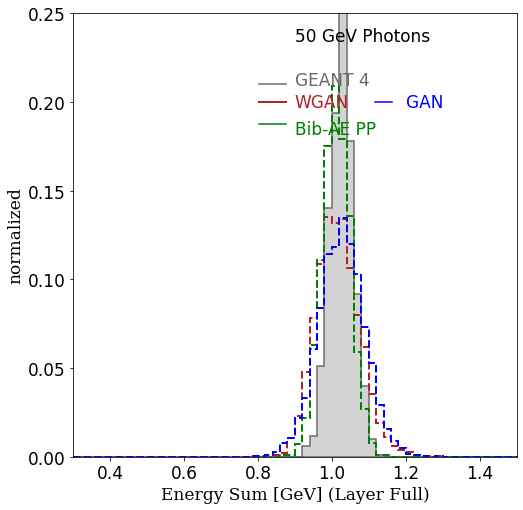

In [98]:
plt_singleEnergy(xesum_g4, xesum_wgan, xesum_bib, xesum_vgan , 50, 1.5, 0.3, bins=60, xtitle="Energy Sum [GeV] (Layer Full)",save_title="sim-xcheck-full")

In [89]:
xesum_wgan

array([1.00549842, 1.13037642, 1.00347079, ..., 1.04618201, 1.07980338,
       1.05334199])

In [71]:
hitWGAN = nhits("wgan50GeV_REC.slcio", 5000, "PandoraClusters" )
hitVGAN = nhits("vgan50GeV_REC.slcio", 5000, "PandoraClusters" )
hitbib = nhits("bibae50GeV_REC.slcio", 1000, "PandoraClusters" )
hitg4 = nhits("nom50GeV_noHCALPFO_REC.slcio", 1000, "PandoraClusters")


In [70]:
numhits

array([852, 906, 766, 730, 894, 915, 846, 889, 862, 773])

In [5]:
def Esum(fName, maxEvt, collection):

    reader = IOIMPL.LCFactory.getInstance().createLCReader()
   
    reader.open( fName )

    nEvt = 0
    esuml = []
    for evt in reader:
        nEvt += 1
        if nEvt > maxEvt:
                break
        col = evt.getCollection(collection)
        for c in col:
            ## get energy
            e = c.getEnergy()
            esuml.append(e)
    esumnp = np.asarray(esuml)
    
    return esumnp
    

In [ ]:
#wgan_e20, wgan_e10 = fracEsum("wgan50GeV_REC.slcio", 5000)
#vgan_e20, vgan_e10 = fracEsum("vgan50GeV_REC.slcio", 5000)
#bib_e20, bib_e10 = fracEsum("bibae50GeV_REC.slcio", 1000)
#g4_e20odd, g4_e10odd = fracEsum("nom50GeV_REC.slcio", 5000, "ECalBarrelSiHitsOdd")


#wgan_esum = Esum("wgan50GeV_REC.slcio", 5000, "EcalBarrelCollectionRec")
#vgan_esum = Esum("vgan50GeV_REC.slcio", 5000, "EcalBarrelCollectionRec")
#bib_esum = Esum("bibae50GeV_REC.slcio", 1000, "EcalBarrelCollectionRec")
#g4sum = Esum("nom50GeV_tcut0_REC.slcio", 1000, "EcalBarrelCollectionRec")


In [34]:
wgan_sim = Esumhit("wgan50GeV_REC.slcio", 5000, "EcalBarrelCollection" )
vgan_sim = Esumhit("vgan50GeV_REC.slcio", 5000, "EcalBarrelCollection" )
bibae_sim = Esumhit("bibae50GeV_REC.slcio", 1000, "EcalBarrelCollection" )
g4_sim = Esumhit("nom50GeV_noHCALPFO_REC.slcio", 1000, "EcalBarrelCollection" )

In [14]:
wgan_cl = Esum("wgan50GeV_REC.slcio", 5000, "PandoraClusters" )
vgan_cl = Esum("vgan50GeV_REC.slcio", 5000, "PandoraClusters" )
bibae_cl = Esum("bibae50GeV_REC.slcio", 1000, "PandoraClusters" )
g4_cl = Esum("nom50GeV_noHCALPFO_REC.slcio", 1000, "PandoraClusters" )

In [15]:
wgan_pfo = Esum("wgan50GeV_REC.slcio", 5000, "PandoraPFOs" )
vgan_pfo = Esum("vgan50GeV_REC.slcio", 5000, "PandoraPFOs" )
bibae_pfo = Esum("bibae50GeV_REC.slcio", 1000, "PandoraPFOs" )
g4_pfo = Esum("nom50GeV_noHCALPFO_REC.slcio", 1000, "PandoraPFOs" )

In [30]:
wgan_digi = Esumhit("wgan50GeV_REC.slcio", 5000, "EcalBarrelCollectionDigi" )
vgan_digi = Esumhit("vgan50GeV_REC.slcio", 5000, "EcalBarrelCollectionDigi" )
bibae_digi = Esumhit("bibae50GeV_REC.slcio", 1000, "EcalBarrelCollectionDigi" )
g4_digi = Esumhit("nom50GeV_noHCALPFO_REC.slcio", 1000, "EcalBarrelCollectionDigi" )

In [17]:
wgan_rec = Esumhit("wgan50GeV_REC.slcio", 5000, "EcalBarrelCollectionRec" )
vgan_rec = Esumhit("vgan50GeV_REC.slcio", 5000, "EcalBarrelCollectionRec" )
bibae_rec = Esumhit("bibae50GeV_REC.slcio", 1000, "EcalBarrelCollectionRec" )
g4_rec = Esumhit("nom50GeV_noHCALPFO_REC.slcio", 1000, "EcalBarrelCollectionRec" )

In [31]:
## convert MIPs to GeV
wgan_digi = wgan_digi * 1.58e-04
vgan_digi = vgan_digi * 1.58e-04
bibae_digi = bibae_digi * 1.58e-04
g4_digi = g4_digi * 1.58e-04 

In [ ]:
#plt_singleEnergy(g4_e20, wgan_e20, bib_e20, vgan_e20 , 50, 1.5, 0.2, bins=50, xtitle="Energy Sum [GeV] (Layer <= 20)",save_title="siml20")
#plt_singleEnergy(g4_e10, wgan_e10, bib_e10, vgan_e10 , 50, 0.8, 0, bins=50, xtitle="Energy Sum [GeV] (Layer > 20)",save_title="siml10")

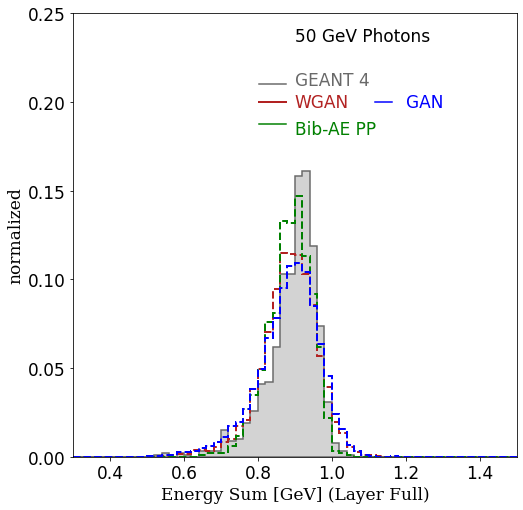

In [36]:
plt_singleEnergy(g4_sim, wgan_sim, bibae_sim, vgan_sim , 50, 1.5, 0.3, bins=60, xtitle="Energy Sum [GeV] (Layer Full)",save_title="sim-full")

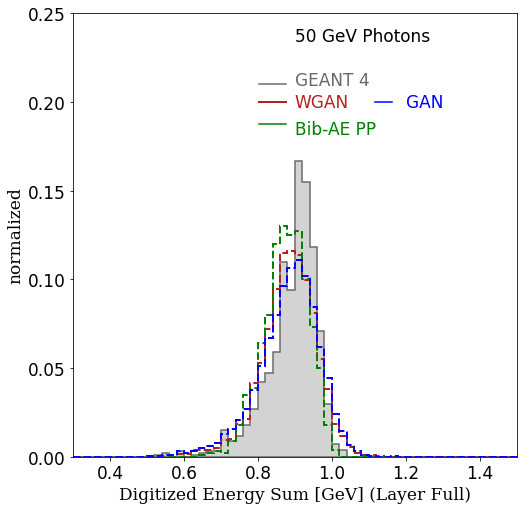

In [37]:
plt_singleEnergy(g4_digi, wgan_digi, bibae_digi, vgan_digi , 50, 1.5, 0.3, bins=60, xtitle="Digitized Energy Sum [GeV] (Layer Full)",save_title="digi-full")

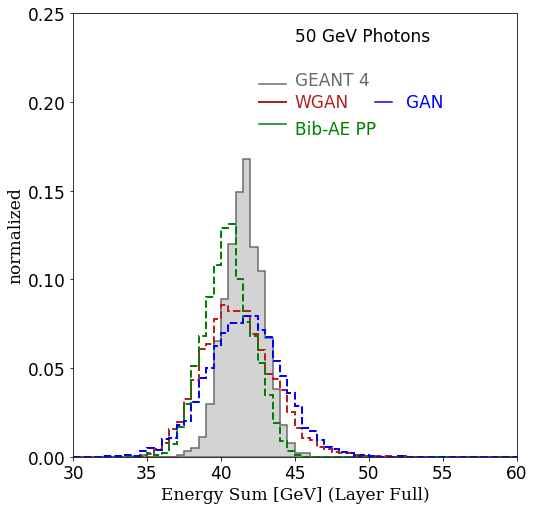

In [26]:
plt_singleEnergy(g4_rec, wgan_rec, bibae_rec, vgan_rec , 50, 60, 30, bins=60, xtitle="Energy Sum [GeV] (Layer Full)",save_title="reco-full")


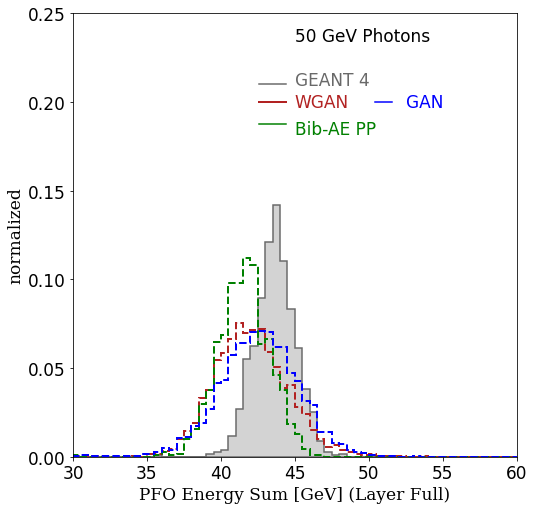

In [27]:
plt_singleEnergy(g4_pfo, wgan_pfo, bibae_pfo, vgan_pfo , 50, 60, 30, bins=60, xtitle="PFO Energy Sum [GeV] (Layer Full)",save_title="pfo-full")


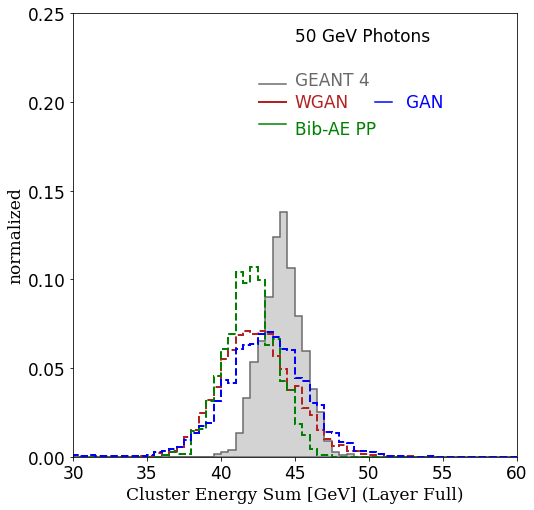

In [28]:
plt_singleEnergy(g4_cl, wgan_cl, bibae_cl, vgan_cl , 50, 60, 30, bins=60, xtitle="Cluster Energy Sum [GeV] (Layer Full)",save_title="cluster-full")

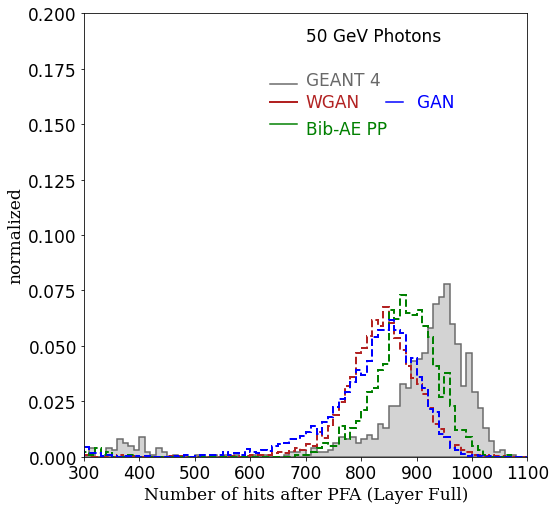

In [85]:
plt_singleEnergy(hitg4, hitWGAN, hitbib, hitVGAN , 50, 1100, 300, bins=80, xtitle="Number of hits after PFA (Layer Full)",save_title="cluster-N-full")

In [92]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
color_list = []
color_list.append('dimgrey')
color_list.append('firebrick')
color_list.append('green')
color_list.append('blue')

linewidth_list = []
linewidth_list.append(1.5)
linewidth_list.append(2)

    
linestyle_list = []
linestyle_list.append('-')
linestyle_list.append('--')

fillcolor_list = []
fillcolor_list.append('lightgrey')
fillcolor_list.append('red')

def plt_singleEnergy(data_real, data_fake, data_fake2, data_fake3, energy_center, maxE, minE, bins, xtitle,save_title):
    figSE = plt.figure(figsize=(8,8))
    axSE = figSE.add_subplot(1,1,1)
    lightblue = (0.1, 0.1, 0.9, 0.3)
    
   
    pSEa = axSE.hist(data_real, bins=bins, range=[minE, maxE], density=None, 
                   weights=np.ones_like(data_real)/(float(len(data_real))), edgecolor=color_list[0], 
                   label = "orig", linewidth=linewidth_list[0],color=fillcolor_list[0],
                   histtype='stepfilled')

    axSE.plot((0.42, 0.48),(0.84, 0.84),linewidth=linewidth_list[0], 
             linestyle=linestyle_list[0], transform=axSE.transAxes, color = color_list[0]) 
    axSE.text(0.50, 0.87, 'GEANT 4', horizontalalignment='left',verticalalignment='top', 
             transform=axSE.transAxes, color = color_list[0])


    
    pSpnEb = axSE.hist(data_fake, bins=pSEa[1], range=None, density=None, 
                   weights=np.ones_like(data_fake)/(float(len(data_fake))), edgecolor=color_list[1], 
                   label = "orig", linewidth=linewidth_list[1], linestyle=linestyle_list[1],
                   histtype='step')

    pSpnEc = axSE.hist(data_fake2, bins=pSEa[1], range=None, density=None, 
                   weights=np.ones_like(data_fake2)/(float(len(data_fake2))), edgecolor=color_list[2], 
                   label = "orig", linewidth=linewidth_list[1], linestyle=linestyle_list[1],
                   histtype='step')
    
    pSpnEc = axSE.hist(data_fake3, bins=pSEa[1], range=None, density=None, 
                   weights=np.ones_like(data_fake3)/(float(len(data_fake3))), edgecolor=color_list[3], 
                   label = "orig", linewidth=linewidth_list[1], linestyle=linestyle_list[1],
                   histtype='step')
    
    axSE.plot((0.42, 0.48),(0.80, 0.80),linewidth=linewidth_list[1], 
             linestyle=linestyle_list[0], transform=axSE.transAxes, color = color_list[1]) 
    
    
    axSE.plot((0.42, 0.48),(0.75, 0.75),linewidth=linewidth_list[0], 
                 linestyle=linestyle_list[0], transform=axSE.transAxes, color = color_list[2]) 
    
    axSE.plot((0.72, 0.68),(0.80, 0.80),linewidth=linewidth_list[0], 
                 linestyle=linestyle_list[0], transform=axSE.transAxes, color = color_list[3]) 
    
    axSE.text(0.50, 0.82, 'WGAN', horizontalalignment='left',verticalalignment='top', 
             transform=axSE.transAxes, color = color_list[1])
    
    axSE.text(0.50, 0.76, 'Bib-AE PP', horizontalalignment='left',verticalalignment='top', 
             transform=axSE.transAxes, color = color_list[2])
    axSE.text(0.75, 0.82, 'GAN', horizontalalignment='left',verticalalignment='top', 
             transform=axSE.transAxes, color = color_list[3])
    

    axSE.set_ylabel('normalized', family='serif')
    axSE.set_xlabel(xtitle, family='serif')
    axSE.set_xlim([minE, maxE])
    axSE.set_ylim([0, 0.25])

  
    #axSE.xaxis.set_minor_locator(MultipleLocator(10))
    #axSE.xaxis.set_major_locator(MultipleLocator(60))


    axSE.text(0.5,
            0.97,
            '{:d} GeV Photons'.format(energy_center), horizontalalignment='left',verticalalignment='top', 
             transform=axSE.transAxes)

    plt.subplots_adjust(left=0.18, right=0.95, top=0.95, bottom=0.18)
    #plt.yscale('log')
    figSE.patch.set_facecolor('white')

    plt.savefig(save_title+ str(energy_center)+"_single_E_dist.png")